In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [110]:
#Read Training File
df_train=pd.read_csv("train.csv")
df_train["source"]="Train"

#Read Test File
df_test=pd.read_csv("test.csv")
df_test["source"]="Test"

#Concat Dataset and split to X and Y
df=pd.concat([df_test,df_train], axis=0)
X=df.drop("SalePrice",axis=1)
y=df["SalePrice"]

#Save source information as series and drop from DF
source=df["source"]
df.drop("source", axis=1, inplace=True)

# Feature Engineering: Cleaning

In [111]:
# Defining categorical and numerical variables
num_cols=X.columns.values[(X.dtypes=="int64")|(X.dtypes=="float64")]
cat_cols=X.columns.values[X.dtypes=="object"]

### Outlier/Data Errors

### Missing Values

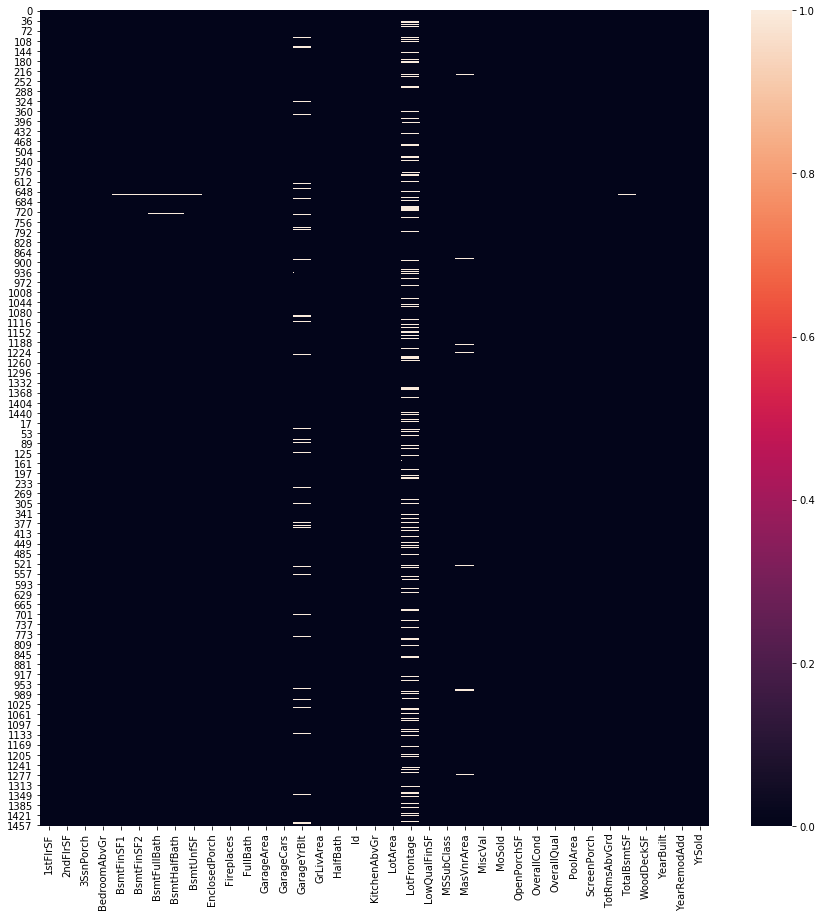

In [112]:
plt.figure(figsize=(15,15))
sns.heatmap(X[num_cols].isnull())

- Deep dive into "GarageYrBlt" and "Lot Frontage"
 - "GarageYrBlt" => insert "YearBuild"
 - "Lot Frontage" => median
- Replace all others with Median Value

In [113]:
# Replace "GarageYrBlt"
X["GarageYrBlt"].describe()

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [114]:
X["GarageYrBlt"]=X["GarageYrBlt"].fillna(X["YearBuilt"])

In [115]:
#Fill other columns
for each in X[num_cols]:
    X[each]=X[each].fillna(np.mean(X[each]))
    #X[each]=X[each].fillna(0)

### Normalization

In [116]:
# Standardize 
for each in X[num_cols]:
    #X[each] = (X[each]-X[each].min())/(X[each].max()-X[each].min())
    X[each] = (X[each]-X[each].mean())/(X[each].std())

### One-Hot-Encoding

In [118]:
for each in cat_cols:
    X[each]=pd.Categorical(X[each])
    dummies=pd.get_dummies(X[each], prefix=str(each))
    #dummies=dummies[1:]
    X=pd.concat([X,dummies],axis=1)
    X.drop(each,axis=1,inplace=True)

## Split Training and Test

In [120]:
#Split Set (using source)
def sync_datasets(X,y):
    X_train = X[source=="Train"]
    y_train = y[source=="Train"]
    X_test= X[source=="Test"]
    return X_train, y_train, X_test

X_train, y_train, X_test = sync_datasets(X,y)

# Feature Selection

In [121]:
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor()

### Drop non-corelating variables

In [122]:
#correlations=pd.concat([X,y], axis=1).corr()["SalePrice"]
#keep_cols=(abs(correlations)>0.1) & (correlations<1)
#keep_cols=keep_cols[0:291]
#Das muss noch anders gelöst werden
#X=X[X.columns.values[keep_cols]]

### Recursive Feature Selection
This step should help us to get on idea on the right number of parameters.

In [123]:
from sklearn.feature_selection import RFECV

In [124]:
rfecv = RFECV(estimator=RandomForest,scoring="explained_variance", step=5)
rfecv.fit(X=X_train,y=y_train)

RFECV(cv=None,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring='explained_variance', step=5, verbose=0)

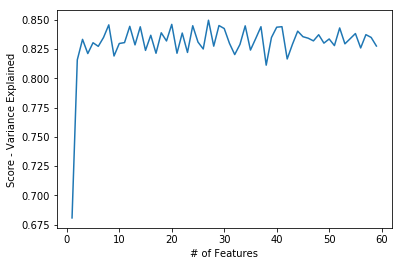

Optimal number of features 131


In [125]:
# Plot relationship #of features and performance
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.xlabel("# of Features")
plt.ylabel("Score - Variance Explained")
plt.show()
print("Optimal number of features {}".format(rfecv.n_features_))

In [126]:
#Select important columns
selected_cols=X_train.columns.values[rfecv.support_]
X_train=X_train[selected_cols]
X_test=X_test[selected_cols]

# Feature Engineering: Creative

## Dependent Variable

In [ ]:
#plt.hist(y_train)

In [ ]:
#plt.hist(np.log(y_train))

In [ ]:
#y_train=np.log(y_train)

# Train Models

In [127]:
#Random Forest Regressor
RandomForest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [128]:
from sklearn.linear_model import LinearRegression
Regression=LinearRegression()
Regression.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [129]:
from sklearn.svm import SVR
SVR=SVR()
SVR.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [130]:
from sklearn.ensemble import AdaBoostRegressor
Ada=AdaBoostRegressor()
Ada.fit(X=X_train,y=y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [131]:
from sklearn.ensemble import GradientBoostingRegressor
Boosting=GradientBoostingRegressor()
Boosting.fit(X=X_train,y=y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [132]:
import xgboost as xgb
boost=xgb.XGBRegressor()
boost.fit(X_train,y_train)

In [156]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train,y_train)

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [157]:
model = [lasso,boost, Regression, RandomForest, SVR, Ada,Boosting]

## Cross-Validation for Model Selection

In [158]:
from sklearn.model_selection import cross_val_score

In [159]:
for each in model:
    scores = cross_val_score(estimator=each,X=X_train, y=y_train, cv=10,scoring='explained_variance') 
    print(str(each)+" "+str(scores.mean()))

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 0.8371217073496225
[20:56:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated 

# Hyperparameter - Tuning

In [144]:
from sklearn.model_selection import GridSearchCV

In [138]:
#params = {"min_samples_leaf":[1,2,3,5,10,15], "min_samples_split": [2,3,5,10,15]}
params = {"min_child_weight":[1,2,3,5,10,15]}

In [147]:
tuning = GridSearchCV(boost,cv=7, param_grid=params)
tuning.fit(X_train, y_train)
tuning.best_params_

In [152]:
RandomForest_tuned = RandomForestRegressor()
RandomForest_tuned.fit(X_train, y_train)
scores = cross_val_score(estimator=RandomForest_tuned,X=X_train, y=y_train, cv=10,scoring='explained_variance') 
print(scores.mean())

0.8371748150474743


# Prediction

In [153]:
prediction = boost.predict(X_test)

In [154]:
prediction

array([122412.89, 166713.62, 172524.64, ..., 154433.88, 122692.04,
       236585.33], dtype=float32)

In [ ]:
# Reverting log
#prediction = np.exp(prediction)

In [155]:
# Writing Prediction to *.csv
submission = pd.read_csv("sample_submission.csv")
submission["SalePrice"]=prediction
submission.to_csv("submission.csv", index=False)

# Learnings

- Vor one-hot-enconding training und test dataset zusammen 
- What is a stratified fold?
- Variance explained for Regression?

# Results

1. Submit: Just one hot-encoding and Random Forest (Default): 0.15554
2. Submit: One hot-encoding and Random Forest (Default), RFECV: 0.15051 (2.857)
3. Submit: Like 2, +Log Target Variable, +Fill missing values with mean instead of 0:
4. Submit: Like 3, - Fill missing values with mean instead of 0: 0.15727
5. Submit: Normalized, median as input, pre-selected features: 0.16282
6. Submit: Model - Regression: 0.16721
7. Submit: Model - Boosting:0.19108 => overfitting
8. Submit: Random Forest, + Missing Values (Garage) + Standardization (just for nums) + Garage NaN more sophisticated:  0.15394
9. Submit: Wie 8, bloß mit Hyperparameter Tuning: 0.16575
10. Submit: gxboost: 0.13471

In [ ]:
prediction

# Ideas
- Descriptive Analysis
 - Years as categorical
- Engineering
 - Remove colinearity
- More Algos
- Hyperparameter

=> xgboost less overfitting